In [165]:
#import relevant libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import timedelta
import sklearn
import math

In [44]:
df = pd.read_csv('/Users/kasper/OneDrive/study/UvA/Master/Data mining/Assignments/Assignment 1 - advanced/dataset_mood_smartphone.csv') #load in the raw data
df.head()

,Unnamed: 0,id,time,variable,value
0,1,AS14.01,2014-02-26 13:00:00.000,mood,6.0
1,2,AS14.01,2014-02-26 15:00:00.000,mood,6.0
2,3,AS14.01,2014-02-26 18:00:00.000,mood,6.0
3,4,AS14.01,2014-02-26 21:00:00.000,mood,7.0
4,5,AS14.01,2014-02-27 09:00:00.000,mood,6.0


In [45]:
df['time'] = pd.to_datetime(df['time']) #set time column to time datatype

In [46]:
df = df[(df['time'] >= '2014-03-01')] #filter out the February dates since they are only applicable for ID .01 and irrelevant
df.head()

,Unnamed: 0,id,time,variable,value
7,8,AS14.01,2014-03-21 09:00:00,mood,6.0
8,9,AS14.01,2014-03-21 11:00:00,mood,6.0
9,10,AS14.01,2014-03-21 15:00:00,mood,7.0
10,11,AS14.01,2014-03-21 19:00:00,mood,6.0
11,12,AS14.01,2014-03-21 21:00:00,mood,6.0


In [47]:
df2 = df.set_index('time').groupby(['id', 'variable']).resample('D').mean().reset_index() #get the mean of the value per day
df2 = df2.drop('Unnamed: 0',axis=1) #drop the unnamed column. (Still not sure how this one gets created due to the line above)
df2.head()

,id,variable,time,value
0,AS14.01,activity,2014-03-20,0.081548
1,AS14.01,activity,2014-03-21,0.134050
2,AS14.01,activity,2014-03-22,0.236880
3,AS14.01,activity,2014-03-23,0.142741
4,AS14.01,activity,2014-03-24,0.078961


In [108]:
pivoted = df2.pivot(index=['id', 'time'], columns='variable', values='value').reset_index() #pivot the table so that we get the variables as column and not row
pivoted.columns.name=None #formatting
pivoted = pivoted[pivoted['mood'].notna()] #filter out all rows where mood has a NaN value. Since the assignment is about mood prediction, this variable needs to be clean
pivoted.head()

,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
20,AS14.01,2014-03-21,0.134050,14.269173,55.095526,53.024000,6.193000,NaN,57.402,29.968875,...,70.418846,NaN,23.0290,NaN,1.0,0.2,0.2,6.20,153.665872,NaN
21,AS14.01,2014-03-22,0.236880,7.781160,51.697063,46.662000,7.025333,NaN,NaN,14.020429,...,37.305000,NaN,39.2070,NaN,1.0,0.6,0.5,6.40,47.613651,1.0
22,AS14.01,2014-03-23,0.142741,12.134396,53.442031,31.448667,10.850750,NaN,NaN,12.137167,...,NaN,NaN,30.0860,30.386,NaN,0.2,0.8,6.80,67.067644,NaN
23,AS14.01,2014-03-24,0.078961,4.982506,47.541687,122.121375,5.684333,NaN,3.010,11.093000,...,83.961000,NaN,89.3660,NaN,1.0,0.8,0.0,6.00,76.772199,NaN
24,AS14.01,2014-03-25,0.098374,10.026874,69.437507,34.103000,10.763500,NaN,NaN,29.803167,...,NaN,29.402875,22.2893,NaN,NaN,0.5,0.5,6.75,169.097283,1.0


In [145]:
final_df = pivoted.fillna(0) #replace all NaN values with 0.
final_df = final_df[pivoted.iloc[:, 2:] >= 0] #filter out all values below 0.
final_df.head()

,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
20,NaN,NaN,0.134050,14.269173,55.095526,53.024000,6.193000,0.0,57.402,29.968875,...,70.418846,0.000000,23.0290,0.000,1.0,0.2,0.2,6.20,153.665872,0.0
21,NaN,NaN,0.236880,7.781160,51.697063,46.662000,7.025333,0.0,0.000,14.020429,...,37.305000,0.000000,39.2070,0.000,1.0,0.6,0.5,6.40,47.613651,1.0
22,NaN,NaN,0.142741,12.134396,53.442031,31.448667,10.850750,0.0,0.000,12.137167,...,0.000000,0.000000,30.0860,30.386,0.0,0.2,0.8,6.80,67.067644,0.0
23,NaN,NaN,0.078961,4.982506,47.541687,122.121375,5.684333,0.0,3.010,11.093000,...,83.961000,0.000000,89.3660,0.000,1.0,0.8,0.0,6.00,76.772199,0.0
24,NaN,NaN,0.098374,10.026874,69.437507,34.103000,10.763500,0.0,0.000,29.803167,...,0.000000,29.402875,22.2893,0.000,0.0,0.5,0.5,6.75,169.097283,1.0


In [116]:
final_df.to_csv('final_df_v1.csv')

In [132]:
X = final_df.drop(['mood', 'id', 'time'], axis=1)
Y = final_df['mood']
print(X.shape)
print(Y.shape)

(1266, 18)
(1266,)


In [133]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler().fit(X)
scaled_X = scaler.transform(X)

In [146]:
from sklearn.model_selection import train_test_split

seed = 42
test_size = 0.20

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1012, 18)
(254, 18)
(1012,)
(254,)


/Users/kasper/opt/anaconda3/envs/dataMining_assignment1_py37/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/kasper/opt/anaconda3/envs/dataMining_assignment1_py37/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/kasper/opt/anaconda3/envs/dataMining_assignment1_py37/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/kasper/op

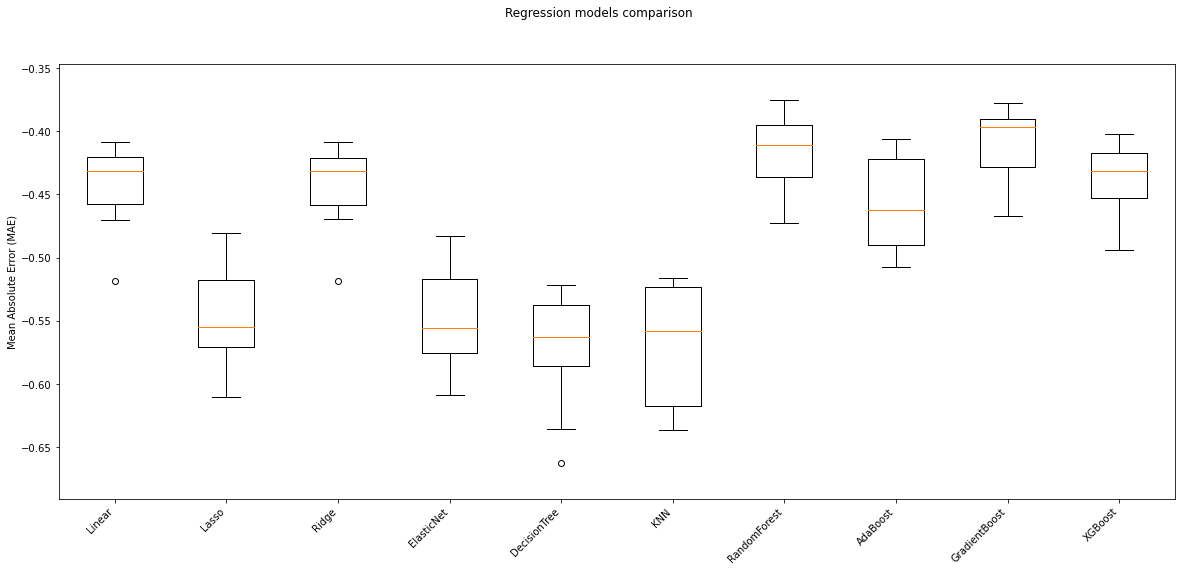

In [147]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
# user variables to tune
folds   = 10
metric  = "neg_mean_absolute_error"

# hold different regression models in a single dictionary
models = {}
models["Linear"]        = LinearRegression()
models["Lasso"]         = Lasso()
models["Ridge"]         = Ridge()
models["ElasticNet"]    = ElasticNet()
models["DecisionTree"]  = DecisionTreeRegressor()
models["KNN"]           = KNeighborsRegressor()
models["RandomForest"]  = RandomForestRegressor()
models["AdaBoost"]      = AdaBoostRegressor()
models["GradientBoost"] = GradientBoostingRegressor()
models["XGBoost"] = XGBRegressor()

# 10-fold cross validation for each model
model_results = []
model_names   = []
for model_name in models:
	model   = models[model_name]
	k_fold  = KFold(n_splits=folds, random_state=seed)
	results = cross_val_score(model, X_train, Y_train, cv=k_fold, scoring=metric)
	
	model_results.append(results)
	model_names.append(model_name)
	print("{}: {}, {}".format(model_name, round(results.mean(), 3), round(results.std(), 3)))

# box-whisker plot to compare regression models
figure = plt.figure(figsize = (20,8))

figure.suptitle('Regression models comparison')
axis = figure.add_subplot(111)
plt.boxplot(model_results)
axis.set_xticklabels(model_names, rotation = 45, ha="right")
axis.set_ylabel("Mean Absolute Error (MAE)")
plt.margins(0.05, 0.1)

In [168]:
model = GradientBoostingRegressor()
model.fit(X_train,Y_train)

#Predicting TEST & TRAIN DATA
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

error_percent = np.mean(np.abs((Y_train - train_predict) / Y_train)) * 100
print("MAPE - Mean Absolute Percentage Error (TRAIN DATA): ",error_percent )
Y_train, train_predict = np.array(Y_train), np.array(train_predict)

mse = sklearn.metrics.mean_squared_error(Y_test, test_predict)
rmse = math.sqrt(mse)
print('Accuracy of this model is: ',100*max(0,rmse)) 

MAPE - Mean Absolute Percentage Error (TRAIN DATA):  4.571886871284058
Accuracy of this model is:  56.26932922781604


In [169]:
model = GradientBoostingRegressor()
model.fit(X_test,Y_test)

#Predicting TEST & TRAIN DATA
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

    
error_percent = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
print("MAPE - Mean Absolute Percentage Error (TEST DATA): ",error_percent )
Y_test, test_predict = np.array(Y_test), np.array(test_predict)

mse = sklearn.metrics.mean_squared_error(Y_test, test_predict)
rmse = math.sqrt(mse)
print('Accuracy of this model is: ',100*max(0,rmse)) 

MAPE - Mean Absolute Percentage Error (TEST DATA):  2.4908740191599668
Accuracy of this model is:  21.994156031962238


In [172]:
model = RandomForestRegressor()
model.fit(X_train,Y_train)

#Predicting TEST & TRAIN DATA
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

error_percent = np.mean(np.abs((Y_train - train_predict) / Y_train)) * 100
print("MAPE - Mean Absolute Percentage Error (TRAIN DATA): ",error_percent )
Y_train, train_predict = np.array(Y_train), np.array(train_predict)

mse = sklearn.metrics.mean_squared_error(Y_test, test_predict)
rmse = math.sqrt(mse)
print('Accuracy of this model is: ',100*max(0,rmse)) 

MAPE - Mean Absolute Percentage Error (TRAIN DATA):  2.4391080796850044
Accuracy of this model is:  57.206475629906315


In [174]:
model = RandomForestRegressor()
model.fit(X_test,Y_test)

#Predicting TEST & TRAIN DATA
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

    
error_percent = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
print("MAPE - Mean Absolute Percentage Error (TEST DATA): ",error_percent )
Y_test, test_predict = np.array(Y_test), np.array(test_predict)

mse = sklearn.metrics.mean_squared_error(Y_test, test_predict)
rmse = math.sqrt(mse)
print('Accuracy of this model is: ',100*max(0,rmse)) 

MAPE - Mean Absolute Percentage Error (TEST DATA):  2.3632766407894685
Accuracy of this model is:  21.07244183976341


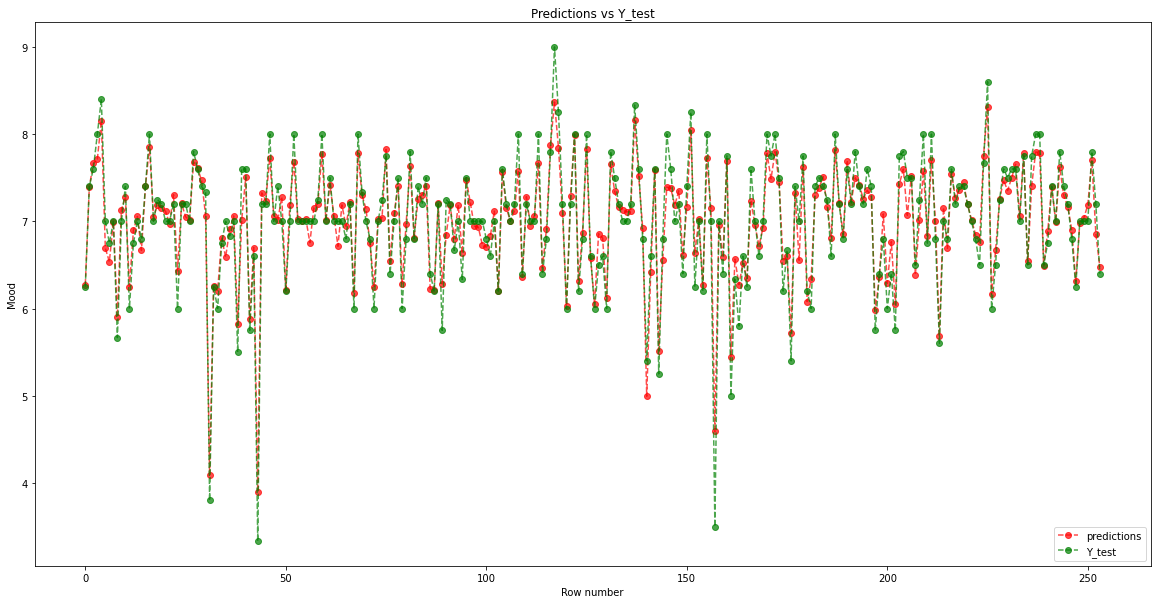

In [175]:
# plot between predictions and Y_test
x_axis = np.array(range(0, test_predict.shape[0]))
plt.figure(figsize=(20,10))
plt.plot(x_axis, test_predict, linestyle="--", marker="o", alpha=0.7, color='r', label="predictions")
plt.plot(x_axis, Y_test, linestyle="--", marker="o", alpha=0.7, color='g', label="Y_test")
plt.xlabel('Row number')
plt.ylabel('Mood')
plt.title('Predictions vs Y_test')
plt.legend(loc='lower right')